<a href="https://colab.research.google.com/github/Interactics/Gait-Estimation-Algorithm/blob/master/LSTM_TrainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 모델 성능 향상시키기
### 만약 모델의 성능을 향상시키고 싶다면 여러 시도를 해볼 수 있습니다.

1. LSTM의 층을 더 쌓기

2. LSTM의 뉴런 수 바꿔보기

3. batch_size 바꿔보기

4. input_shape 바꿔보기

5. 스케일러 바꿔보기

6. dropout 사용하기(그러나 시계열에서 dropout을 사용해도 되는지는 잘 모르겠네요)

7. LSTM 대신 GRU 사용해보기

참고 : https://ebbnflow.tistory.com/135

참고 : https://qwerty1434.github.io/%EB%8B%A4%EC%A4%91%EB%B3%80%EC%88%98%EC%9D%98-%ED%83%80%EC%9E%84%EC%8B%9C%EB%A6%AC%EC%A6%88-LSTM%EC%97%B0%EC%8A%B5 


In [178]:
from tensorflow.contrib import rnn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

#Importing DATA

#Training data preprocessing


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 입력


In [0]:
rawData = pd.read_csv('0305WS2236origininform.csv', index_col = False)
rawData_X_train = trainData[['theta_leftknee', 'theta_shin_vs_ground', 'velocity_knee_left']]
rawData_y_train = trainData[['velocity_human']]

# 데이터 스케일링
## - MinMax 스케일링


In [0]:
###data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

##scaling
### Data TEST
sc_x = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))

X_mM_training = sc_x.fit_transform(rawData_X_train)
y_mM_training = sc_y.fit_transform(rawData_y_train)

# ###Test
# X_std_test = sc_x.transform(X_test)
# y_std_test = sc_y.transform(y_test[:, np.newaxis]).flatten()

# 시퀀스 데이터로 변환하기
## 타임 시리즈로 변환하도록 하는 함수.
t-(n_in)부터 t+(n_out)까지로 데이터를 변환해줌.
 

In [0]:
from pandas import DataFrame

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

# 시퀀스 시리즈에 맞는 데이터형태로 변화

In [0]:
reframed_X = series_to_supervised(X_mM_training, 3, 3) #t-1시점,t시점 데이터를 한 행으로 둔다
values = reframed_X.values #np.array화 
data_y = pd.DataFrame(scaledY).shift(-5).dropna().values #y 데이터 이동시킨 후 NaN 제거

# 트레이닝 데이터, 테스트 데이터 분할

In [0]:
####Training
X_train = values[:900, :]
y_train= data_y[:900]

####Test
X_test = values[900:1000, :]
y_test = data_y[900:1000]

# 학습 모델 설정

In [192]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Flatten
import keras.backend as K 
from keras.callbacks import EarlyStopping

#model's HyperParameter setting
Unit = 50
timesteps = seq_length = 30
data_dim = 3
hidden_dim = 100
output_dim = 1 
learing_rate = 0.0005
iterations = 50_000
Batch = 64
Epochs = 500

# X데이터 차원 변환
X_train_t = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_t = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#모델 설정
K.clear_session()
model = Sequential() # Sequeatial Model 
model.add(LSTM(Unit, input_shape=(X_train_t.shape[1], X_train_t.shape[2]))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') #Regression Model에서는 민스퀘어 에러를 loss로 사용하자.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#모델 트레이닝

In [0]:
history = model.fit(X_train_t, y_train, epochs=100, batch_size=Batch, verbose=2, use_multiprocessing=False, validation_data=(X_test, y_test) )

# 모델 평가

---------Training---------
Training MSE : 0.039
Training R_2score : -2.107
Training MAE : 0.165


-----------Test-----------
Test MSE : 0.080
Test R_2score : -9.999
Test MAE : 0.271


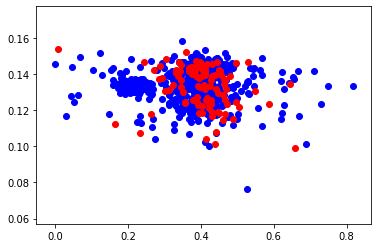

In [201]:
y_pred = model.predict(X_train_t)
y_pred_t = model.predict(X_test_t)

## model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
print('---------Training---------')

print('Training MSE : %.3f' %(mean_squared_error(y_train, y_pred)))
print('Training R_2score : %.3f' %(r2_score(y_train, y_pred)))
print('Training MAE : %.3f' %(mean_absolute_error(y_train, y_pred)))

print('\n\n-----------Test-----------')

print('Test MSE : %.3f' %(mean_squared_error(y_test, y_pred_t )))
print('Test R_2score : %.3f' %(r2_score(y_test, y_pred_t )))
print('Test MAE : %.3f' %(mean_absolute_error(y_test, y_pred_t)))

plt.scatter(y_train, y_pred, c='blue')
plt.scatter(y_test, y_pred_t, c= 'red')
plt.show()

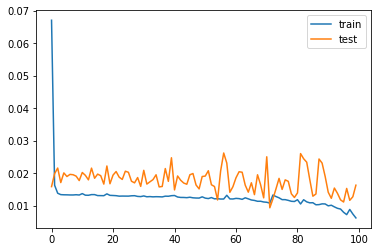

In [167]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

## 모델 평가

In [0]:
# make a prediction
yhat = model.predict(X_test)

# invert scaling for forecast
inv_yhat = MmY.inverse_transform(yhat)

# invert scaling for actual
y_test = testY.reshape((len(y_test), 1))
inv_y = MmY.inverse_transform(y_test)

# calculate RMSE
rmse1 = np.sqrt(mean_squared_error(yhat, y_test))
rmse2 = np.sqrt(mean_squared_error(inv_y, inv_yhat))

In [198]:
print('===모델 평가===')
print('MinMax 스케일링 상태의 RMSE:\n', rmse1)
print('\n실제 추정 상태의 RMSE:\n', rmse2)

===모델 평가===
MinMax 스케일링 상태의 RMSE:
 0.1278443449871407

실제 추정 상태의 RMSE:
 0.8346907100804869


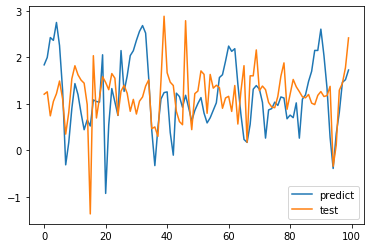

In [199]:
import matplotlib.pyplot as plt
plt.plot(inv_yhat, label='predict')
plt.plot(inv_y, label='test')

plt.legend()
plt.show()